In [33]:
import random
from typing import List

import numpy as np
import einops
import matplotlib.pyplot as plt
import torch
from torchtyping import TensorType, patch_typeguard
from tqdm.notebook import tqdm

from hand import CharTokenizer, PositionEncoder, AttentionOnlyTransformer
from exos import EXOS

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
tokenizer = CharTokenizer(list("123+="), 5)

def gen_goal(tokenizer: CharTokenizer, count: int):
    x = [
        "".join(
            random.choice(tokenizer.vocab[1:])
            for _ in range(random.randint(3, tokenizer.max_len)))
        for _ in range(count)
    ]
    x = tokenizer.encode(x)
    y = x[:, -2].unsqueeze(1)
    return x, y

In [ ]:
tokenizer = CharTokenizer(list("1234567890+="), 8)
def gen_1():
    a = random.randint(0, 5)
    b = random.randint(0, 4)
    s = f"{a}+{b}={a+b}"
    x = s[:random.randrange(s.index('=') + 1, len(s))]
    return x, s[len(x)]

tokenizer = CharTokenizer(list("1234"), 3)
def gen_1():
    x = random.choice(["11", "12", "21", "22"])
    y = str(sum(map(int, x)))
    return x, y

def gen_goal(_, count: int):
    xs, ys = zip(*[gen_1() for _ in range(count)])
    xs = tokenizer.encode(list(xs))
    ys = tokenizer.encode(list(ys))[:,-1].unsqueeze(1)
    return xs, ys

In [2]:
PB = "XOR"
EXO = EXOS[PB]
tokenizer = EXO.tokenizer
def gen_goal(n: int):
    xs, ys = EXO.generate(n)
    xs = EXO.tokenizer.encode(xs)
    ys = EXO.tokenizer.encode(ys, pad=False)
    return xs, ys
EXO

XOR
Complete by 1 if the two digits are different and by 0 if they are the same.

Alphabet: 0: ''  1: 0  2: 1
Input length: 2
Examples:
  11 → 0
  10 → 1
  10 → 1
  10 → 1
  11 → 0

0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 loss: 1.241444706916809
Epoch 100 loss: 0.9914447069168091
Epoch 200 loss: 1.0414446592330933
Epoch 300 loss: 1.0114446878433228
Epoch 400 loss: 1.0214447975158691
Epoch 500 loss: 1.1114447116851807
Epoch 600 loss: 1.0514448881149292
Epoch 700 loss: 1.0814448595046997
Epoch 800 loss: 1.0814448595046997
Epoch 900 loss: 0.9814447164535522


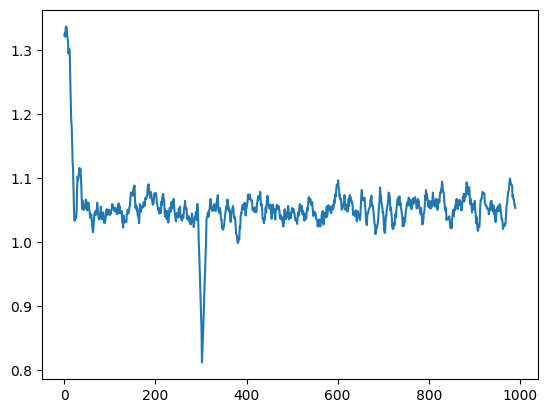

In [53]:
from torch.nn import Parameter
from hand import pprint_2d_tensor, set_debug


epochs = 1000
batch_size = 100
lr = 0.01
weight_decay = 0.01
depth = 4
heads = 2
embedding_size = 12

# pos_encoder=torch.eye(tokenizer.max_len, embedding_size)
pos_encoder = torch.cat([
    torch.zeros(tokenizer.max_len, 3),
    torch.eye(tokenizer.max_len),
    torch.zeros(tokenizer.max_len, embedding_size - tokenizer.max_len - 3),
    ], dim=1)
pprint_2d_tensor(pos_encoder)
transformer = AttentionOnlyTransformer(
    voc_size=tokenizer.vocab_size, 
    embedding_size=embedding_size,
    depth=depth,
    heads=heads,
    pos_encoder=pos_encoder,
)

if "Force (un)embedding":
    transformer.embedding.weight = Parameter(
        torch.eye(*transformer.embedding.weight.shape), requires_grad=False)
    transformer.unembedding = Parameter(transformer.embedding.weight.T, requires_grad=False)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr, weight_decay=weight_decay)

set_debug()

perfs = []
# Training
for epoch in tqdm(range(epochs)):
    xs, ys = gen_goal(batch_size)
    preds = transformer(xs)
    lost = loss(preds, torch.nn.functional.one_hot(ys, tokenizer.vocab_size).squeeze(1).float())
    lost.backward()
    optimizer.step()
    optimizer.zero_grad()

    perfs.append(lost.item())
    if epoch % (epochs // 10) == 0:
        print(f"Epoch {epoch} loss: {lost}")

plt.plot(np.convolve(perfs, np.ones(10)/10, mode='valid'))

In [54]:
# Testing
EXO.test(transformer, 1000)

11 → 1 EXPECTED 0	'': 0.00  0: 0.00  1: 1.00
10 → 1         	'': 0.00  0: 0.00  1: 1.00
01 → 1         	'': 0.00  0: 0.00  1: 1.00
11 → 1 EXPECTED 0	'': 0.00  0: 0.00  1: 1.00
10 → 1         	'': 0.00  0: 0.00  1: 1.00
01 → 1         	'': 0.00  0: 0.00  1: 1.00
01 → 1         	'': 0.00  0: 0.00  1: 1.00
00 → 1 EXPECTED 0	'': 0.00  0: 0.00  1: 1.00
01 → 1         	'': 0.00  0: 0.00  1: 1.00
11 → 1 EXPECTED 0	'': 0.00  0: 0.00  1: 1.00
Loss: 1.06  Accuracy: 491 / 1000


(491, 1.0604448318481445)

# Inspection of the model

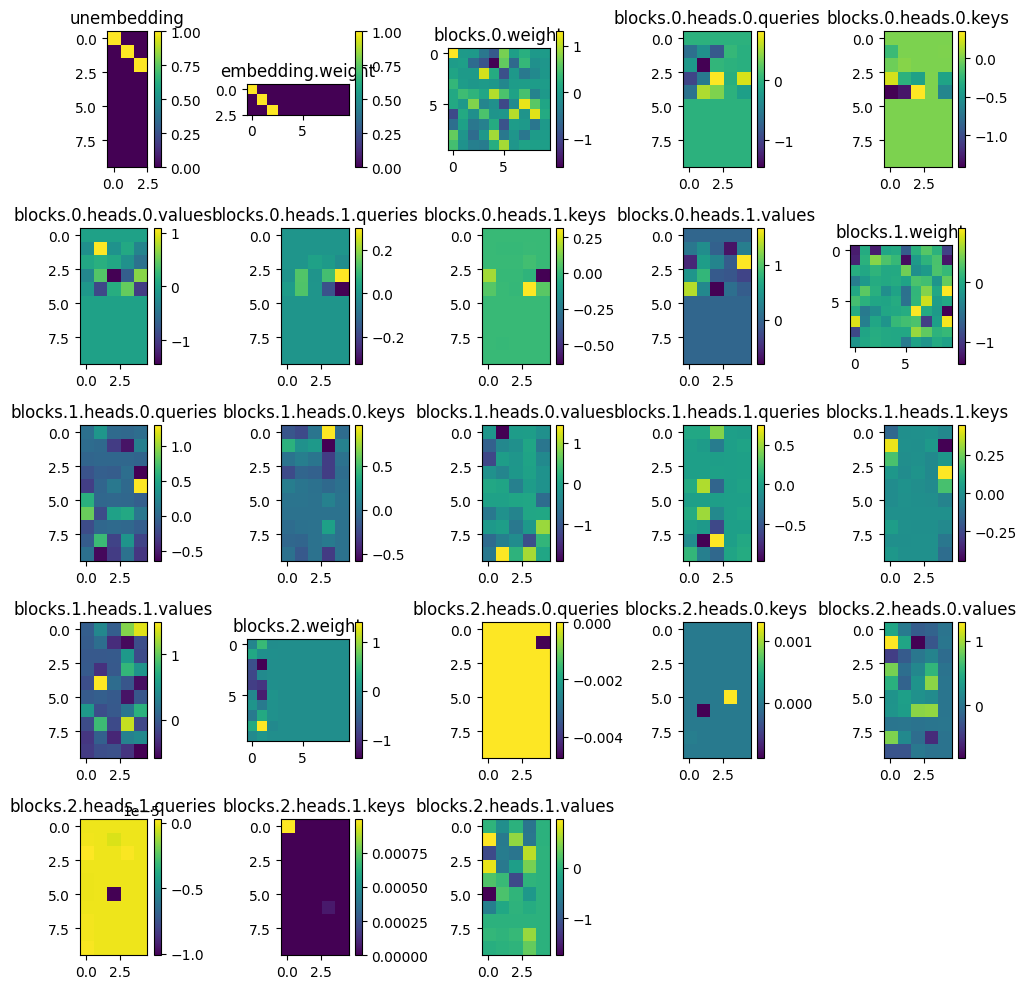

In [42]:
from hand import show_model

show_model(transformer)

In [ ]:
emb = transformer.embeding.weight.detach().numpy()
unemb = transformer.unembeding.weight.detach().numpy()
plt.imshow(emb @ unemb.T)
plt.colorbar()

# Comparision with hand made

 ac → a         	'': 0.00  a: 1.00  b: 0.00  c: 0.00
 ab → a         	'': 0.00  a: 1.00  b: 0.00  c: 0.00
bbb → b         	'': 0.00  a: 0.00  b: 1.00  c: 0.00
 ba → b         	'': 0.00  a: 0.00  b: 1.00  c: 0.00
abb → b         	'': 0.00  a: 0.00  b: 1.00  c: 0.00
 ab → a         	'': 0.00  a: 1.00  b: 0.00  c: 0.00
 cc → c         	'': 0.00  a: 0.00  b: 0.00  c: 1.00
bac → a         	'': 0.00  a: 1.00  b: 0.00  c: 0.00
 ca → c         	'': 0.00  a: 0.00  b: 0.00  c: 1.00
 ab → a         	'': 0.00  a: 1.00  b: 0.00  c: 0.00
Loss: 0.74  Accuracy: 100 / 100


(100, 0.7436684370040894)

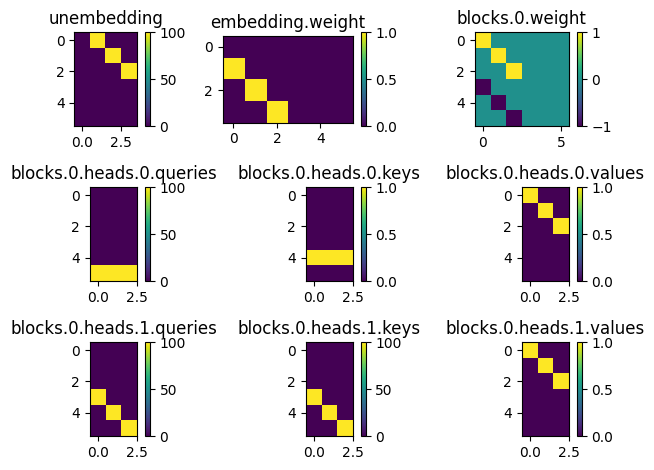

In [7]:
from solutions.cycle_two import cycle_two, EXO
model = cycle_two()

show_model(model)

def perturbate(model: torch.nn.Module):
    for param in model.parameters()

EXO.test(model)
